# Examples <br>



Before starting, remember to activate the environment:  <br>
**source env/bin/activate**





In [1]:
from intrinsic_dimension import intrinsic_dimension, section_id, secondary_structure_id
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns
import logging
from moleculekit.molecule import Molecule

To provide examples of how ID can be applied we used Villin as a protein model. The trajectories are sampled from D. E. Shaw.

In particular, we sampled six trajectories, three representing the folded state, three the unfolded one.

**CITARE CORRETTAMENTEEEEEEEEEE**

By computing ID as ``local`` it is possible to see how this value evolves along the trajectory, we called it **Instantaneous ID**.

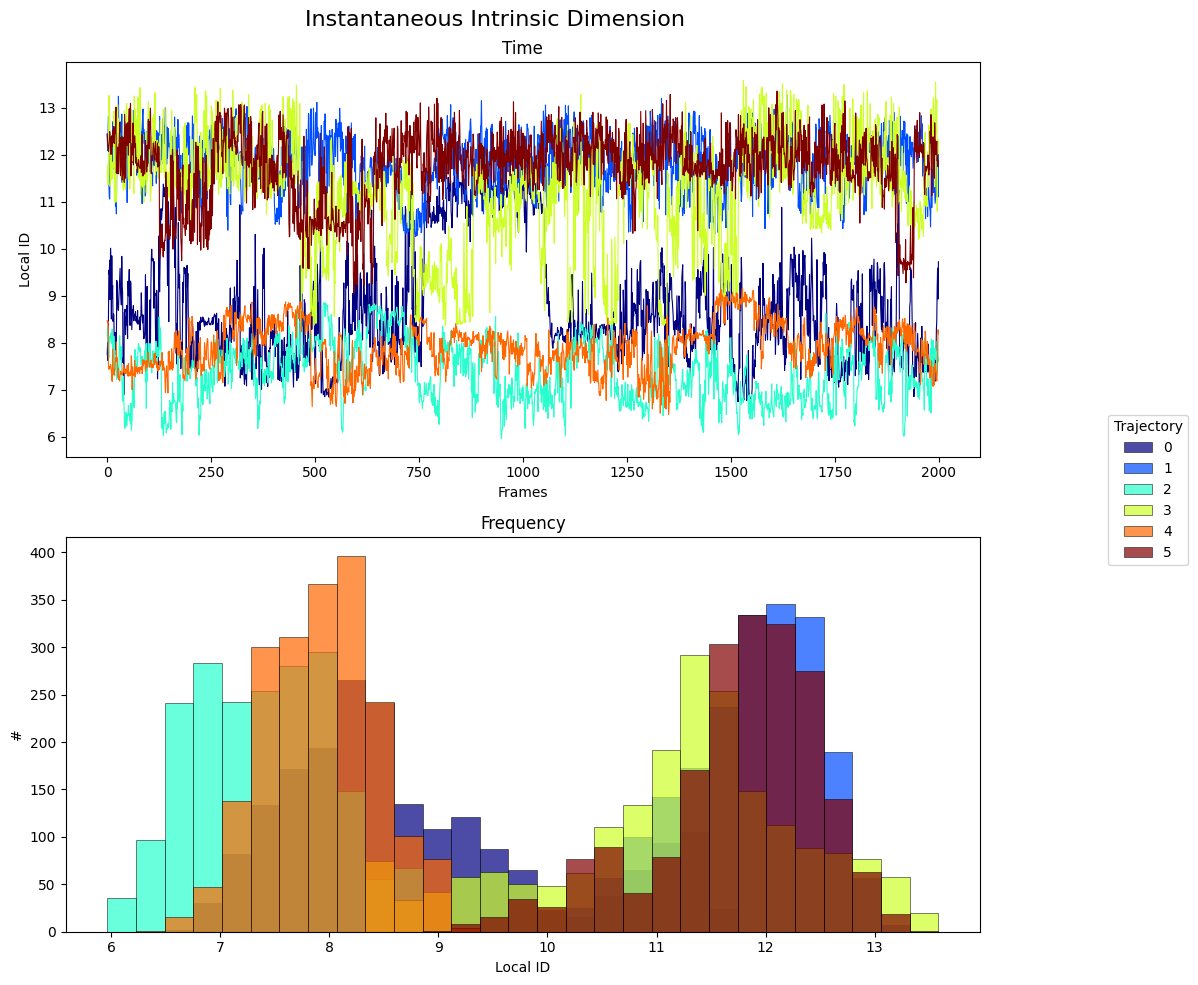

In [2]:
states = [0, 1, 2, 3, 4, 5]
colors = plt.cm.jet(np.linspace(0, 1, len(states)))
state_ids = []

fig, ax = plt.subplots(figsize=(10, 10), nrows=2)
fig.suptitle("Instantaneous Intrinsic Dimension", fontsize=16) 
#instantaneous id
for i, s in enumerate(states):
    mean_all, mean_last, local_id = intrinsic_dimension(topology='examples/villin/2F4K.pdb', trajectory=f'examples/villin/2F4K_{s}.xtc', projection_method='Distances',projection_kwargs = {'step':3}, id_method='local', verbose=False)
    frames = np.arange(len(local_id)) 
    state_ids.append(local_id)

    ax[0].plot(frames, local_id, color=colors[i], linewidth=0.8)
ax[0].set_xlabel("Frames")
ax[0].set_ylabel("Local ID")
ax[0].set_title("Time")
#x[0].legend(bbox_to_anchor=(1.2, 0.5), loc="center right", title='Trajectory')       

#####################
#id frequency
all_values = np.concatenate(state_ids)  # common bin width
bins = np.linspace(all_values.min(), all_values.max(), 30)
for i, local_id in enumerate(state_ids):
    ax[1].hist(local_id, bins=bins, alpha=0.7, label=f"{i}", color=colors[i], edgecolor='black', linewidth=0.5)
ax[1].set_xlabel("Local ID")
ax[1].set_ylabel("#")
ax[1].set_title("Frequency")

fig.legend(bbox_to_anchor=(1.20, 0.5), loc="center right", title='Trajectory')
plt.tight_layout()
plt.savefig('instantaneous_ID_distance.png')
plt.show()


Given the neat division in two groups of ID, we divide the trajectories in "folded" and "unfolded" by setting a threshold at ID<12.5.
ID identifies two clearly distinguishible groups of values ("high" ID for trajectories 1, 3, 5; "low" ID for trajectories 0, 2, 4), corresponding to the folded and unfolded states. 

For this reason, we can define a threshold at ID<12.5 to determine the protein's state. This can be done both with ``global`` ID and the mean of the ``local`` ID along the trajectory.



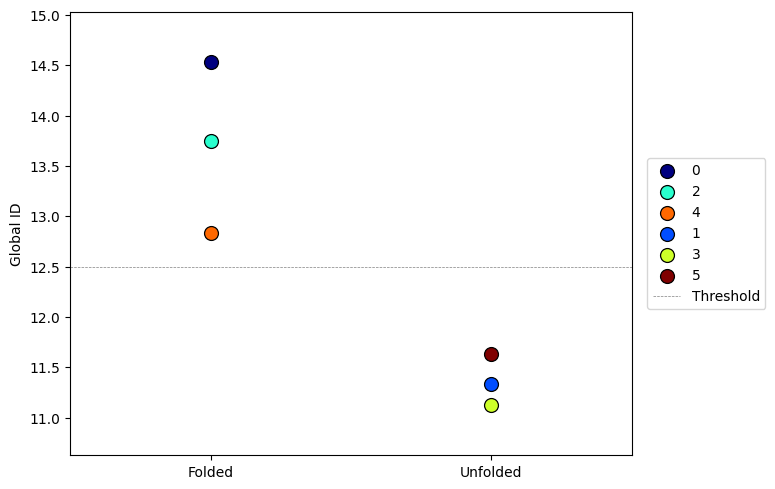

In [2]:
proj = {'dihedrals':'psi'} #changed default angles to compute
states = [0, 1, 2, 3, 4, 5]
colors = plt.cm.jet(np.linspace(0, 1, len(states)))
results=[]
for s in states: #using verbose=False to remove multiple logging infos
    global_all, gid100 = intrinsic_dimension(topology='examples/villin/2F4K.pdb', trajectory=f'examples/villin/2F4K_{s}.xtc', projection_method='Dihedrals', id_method='global' , projection_kwargs=proj, verbose=False)
    results.append({
        'state': s,
        'mean_all': global_all,
        'mean_last': gid100,
            })
results=pd.DataFrame(results)
results['folded'] = results['mean_all'] < 12.5 #threshold set based on instantaneous ID distributions

plt.figure(figsize=(8, 5))
group_labels = {True: "Folded", False: "Unfolded"}
for i, (key, group) in enumerate(results.groupby('folded')):
    x_base = i  # 0 or 1
    for j, (_, row) in enumerate(group.iterrows()):
        x = x_base 
        y = row['mean_all']
        color_idx = states.index(row['state'])
        plt.scatter(x, y, color=colors[color_idx], edgecolor='black', linewidth=0.9, s=100, label=row['state'])

plt.xticks([0, 1], ['Folded', 'Unfolded'])
plt.xlim(-0.5, 1.5)
plt.hlines(y=12.5, xmin=-0.5, xmax=1.5, linestyles="--", colors="gray", label="Threshold", linewidth = 0.5)
plt.ylabel("Global ID")
#plt.title("Global ID defines folding/unfolding state")
plt.ylim(results['mean_all'].min() - 0.5, results['mean_all'].max() + 0.5)
plt.legend(bbox_to_anchor=(1.25, 0.5), loc="center right")
plt.tight_layout()
plt.savefig('average_ID_dihedral.png')
plt.show()

Similarly, with <span class="mark"><code>section_id</code></span>, it is possible to visualise, for each window, the value of ID along the trajectory (both as ``global`` ID and ``local``)

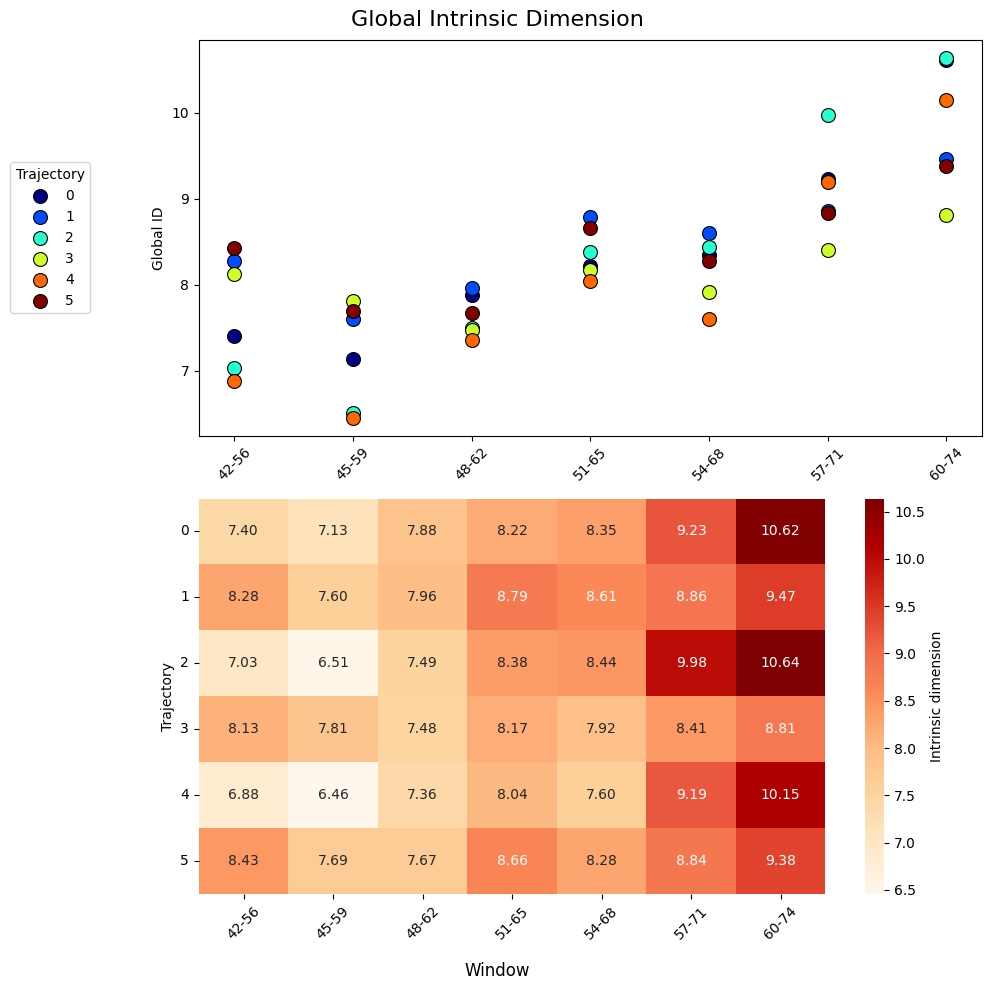

In [4]:
proj = {'dihedrals':'psi'} #changed default angles to compute
states = [0, 1, 2, 3, 4, 5]
colors = plt.cm.jet(np.linspace(0, 1, len(states)))
all_results = []
for s in states: 
    results = section_id(topology='examples/villin/2F4K.pdb', trajectory=f'examples/villin/2F4K_{s}.xtc', window_size = 15, stride = 3, projection_method='Dihedrals', id_method='global' , projection_kwargs=proj, verbose=False)
    results["state"] = s  
    all_results.append(results)
results = pd.concat(all_results, ignore_index=True)
results['window'] = results["start"].astype(str) + "-" + results["end"].astype(str)

grouped_data = results.groupby(['state', 'window'], as_index=False)['entire simulation'].mean()
pivot_data = grouped_data.pivot(index='state', columns='window', values='entire simulation')
ordered_cols = sorted(pivot_data.columns, key=lambda w: int(w.split("-")[0]))
pivot_data = pivot_data[ordered_cols]

fig, axes = plt.subplots(figsize=(10, 10), nrows = 2)
fig.suptitle("Global Intrinsic Dimension", fontsize=16) 
for state, color in zip(states, colors):
    subset = results[results['state'] == state]
    x = subset['window']
    y = subset['entire simulation']
    axes[0].scatter(x, y, color=color, edgecolor='black', linewidth=0.8, s=100, label=f"{state}")

axes[0].set_xticks(sorted(results['window'].unique(), key=lambda w: int(w.split("-")[0])))
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylabel("Global ID")
axes[0].legend(title="Trajectory", bbox_to_anchor=(-0.25, 0.5), loc='center left')

######
pivot_data.columns.name = None
sns.heatmap(pivot_data, cmap="OrRd", annot=True, fmt=".2f", ax=axes[1], cbar_kws={'label': 'Intrinsic dimension'})
axes[1].set_ylabel("Trajectory")
axes[1].tick_params(axis='x', rotation=45, labelrotation=45)
axes[1].tick_params(axis='y', rotation=0)

fig.supxlabel("Window")
plt.tight_layout()
plt.savefig('global_ID_sections.png')
plt.show()


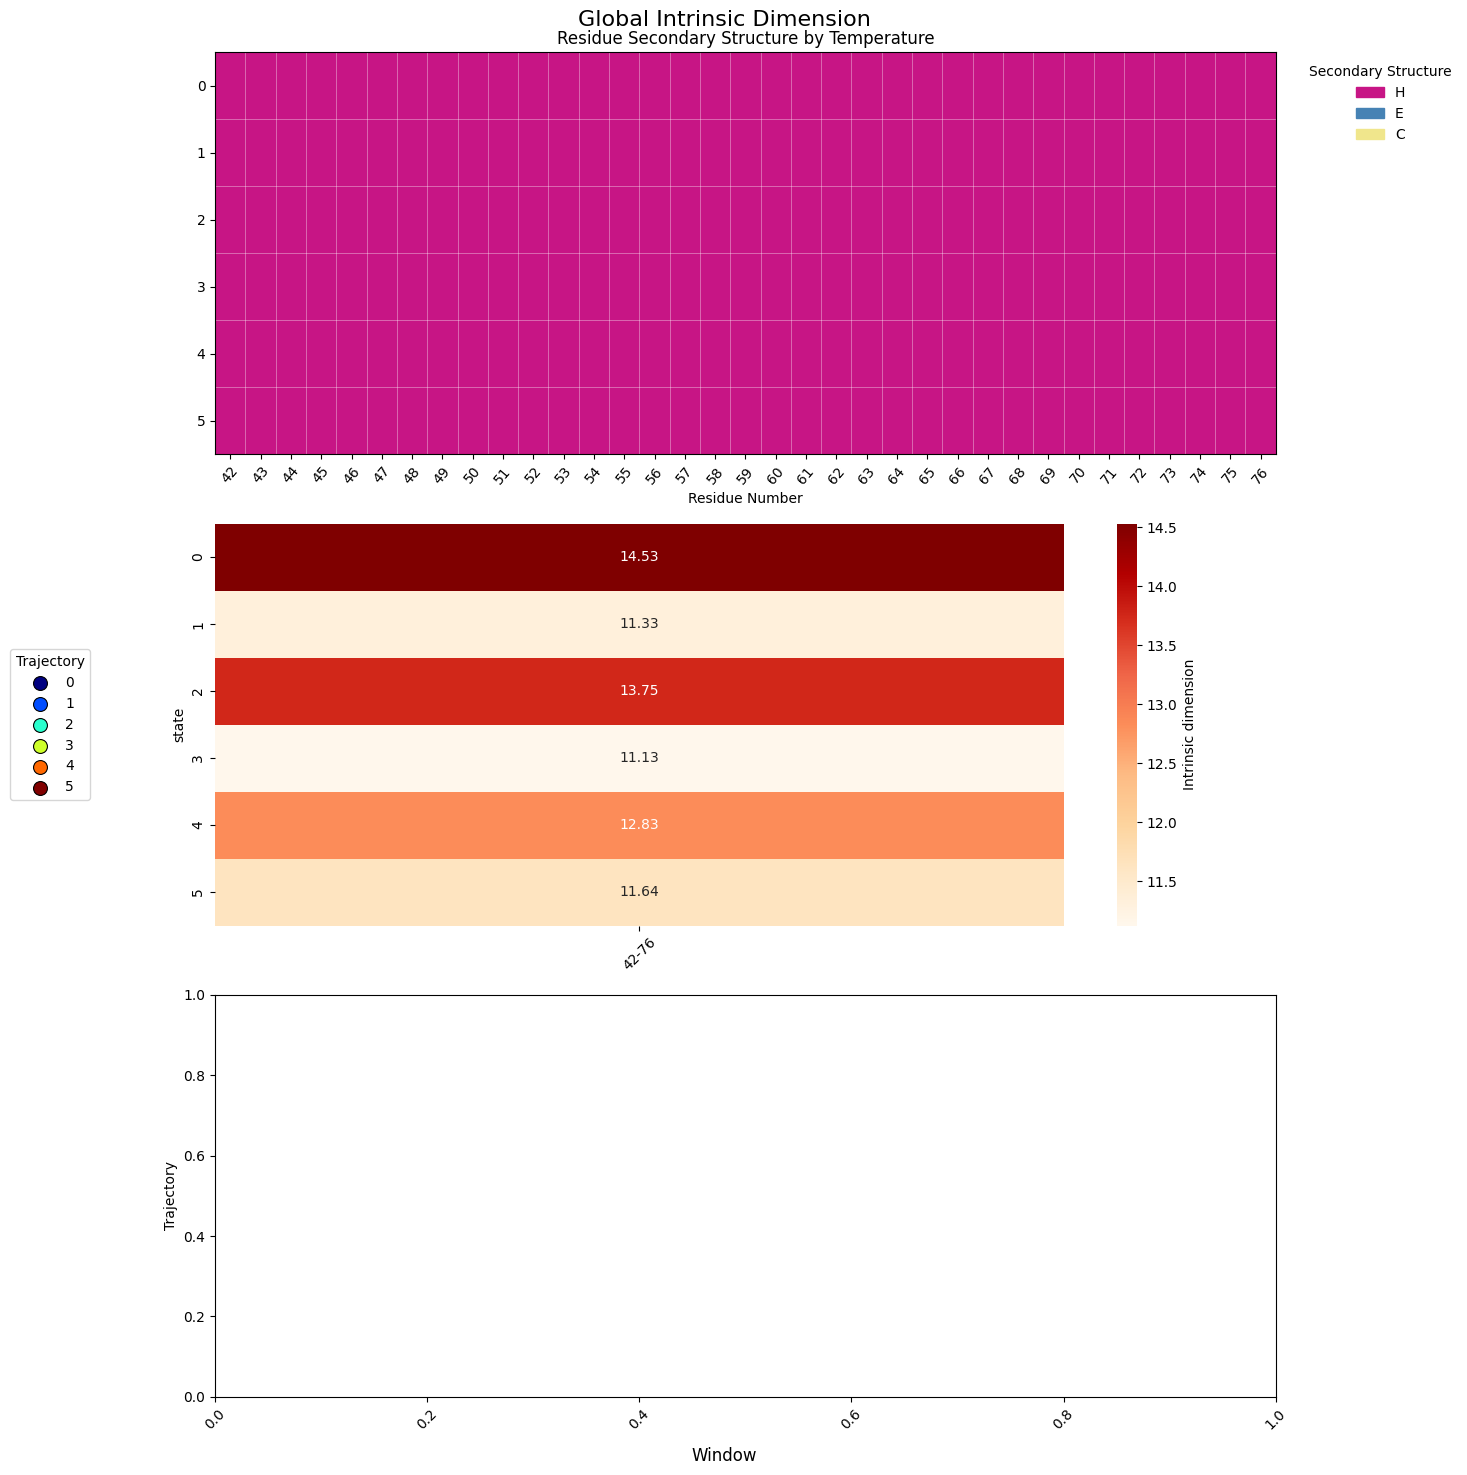

In [9]:
proj = {'dihedrals':'psi'} #changed default angles to compute
states = [0, 1, 2, 3, 4, 5]
colors = plt.cm.jet(np.linspace(0, 1, len(states)))
all_results = []
ss_types = ['H', 'E', 'C']
ss_colors = {'H': 'mediumvioletred', 'E': 'steelblue', 'C': 'khaki'}
ss_assignments = []
residue_numbers = None

for s in states: 
    results, ss_table = secondary_structure_id(topology='examples/villin/2F4K.pdb', trajectory=f'examples/villin/2F4K_{s}.xtc', simplified=True, projection_method='Dihedrals', id_method='global' , projection_kwargs=proj, verbose=False)
    results["state"] = s  
    if residue_numbers is None:
        residue_numbers = ss_table['resid index'].values
    ss_assignments.append(ss_table['sec str type'].values)
    results['trajectory'] = s   
    all_results.append(results)

results = pd.concat(all_results, ignore_index=True)
results['window'] = results["start"].astype(str) + "-" + results["end"].astype(str)

grouped_data = results.groupby(['state', 'window'], as_index=False)['entire simulation'].mean()
pivot_data = grouped_data.pivot(index='state', columns='window', values='entire simulation')
ordered_cols = sorted(pivot_data.columns, key=lambda w: int(w.split("-")[0]))
pivot_data = pivot_data[ordered_cols]

fig, axes = plt.subplots(3, 1, figsize=(15, 15))
fig.suptitle("Global Intrinsic Dimension", fontsize=16) 

ss_to_num = {ss: i for i, ss in enumerate(ss_types)}
num_data = np.array([[ss_to_num[ss] for ss in row] for row in ss_assignments])
cmap = ListedColormap([ss_colors[ss] for ss in ss_types])
im = axes[0].imshow(num_data, aspect='auto', cmap=cmap, extent=[residue_numbers[0]-0.5, residue_numbers[-1]+0.5, len(states)-0.5, -0.5])
for x in np.arange(residue_numbers[0]-0.5, residue_numbers[-1]+1.5, 1):
    axes[0].axvline(x=x, color='white', linewidth=0.5, alpha=0.5)
for y in np.arange(-0.5, len(states)+0.5, 1):
    axes[0].axhline(y=y, color='white', linewidth=0.5, alpha=0.5)
axes[0].grid(False)
axes[0].set_xticks(residue_numbers)
axes[0].set_yticks(np.arange(len(states)))
axes[0].set_yticklabels([f"{t}" for t in states])
axes[0].set_xlabel('Residue Number')
axes[0].set_title('Residue Secondary Structure by Temperature')
axes[0].tick_params(axis='x', rotation=50)  

legend_elements = [plt.Rectangle((0,0), 1, 1, color=ss_colors[ss], label=ss) for ss in ss_types]
axes[0].legend(handles=legend_elements, bbox_to_anchor=(1.02, 1), loc='upper left', title='Secondary Structure', frameon=False, facecolor='white')


for state, color in zip(states, colors):
    subset = results[results['state'] == state]
    x = subset['window']
    y = subset['entire simulation']
    axes[1].scatter(x, y, color=color, edgecolor='black', linewidth=0.8, s=100, label=f"{state}")

axes[1].set_xticks(sorted(results['window'].unique(), key=lambda w: int(w.split("-")[0])))
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylabel("Global ID")
axes[1].legend(title="Trajectory", bbox_to_anchor=(-0.25, 0.5), loc='center left')

######
pivot_data.columns.name = None
sns.heatmap(pivot_data, cmap="OrRd", annot=True, fmt=".2f", ax=axes[1], cbar_kws={'label': 'Intrinsic dimension'})
axes[2].set_ylabel("Trajectory")
axes[2].tick_params(axis='x', rotation=45, labelrotation=45)
axes[2].tick_params(axis='y', rotation=0)

fig.supxlabel("Window")
plt.tight_layout()
plt.savefig('global_ID_ss.png')
plt.show()


In [ ]:
#DA CANELLARE

#states = [0, 1, 2, 3, 4, 5]
states = [1]
colors = plt.cm.jet(np.linspace(0, 1, len(states)))
#estimators = ['CorrInt', 'DANCo', 'ESS', 'FisherS','KNN', 'lPCA', 'MADA', 'MiND_ML', 'MLE', 'MOM', 'TLE', 'TwoNN']
estimators = ['TwoNN', 'TwoNN']

mol_proj = 'Distance'


# One subplot per estimator
fig, axs = plt.subplots(nrows=1, ncols=len(estimators), figsize=(6 * len(estimators), 5), sharey=True)

for col, estimator in enumerate(estimators):
    ax = axs[col] if len(estimators) > 1 else axs  # Support for single estimator case

    for i, s in enumerate(states):
        mean_all, mean_last, local_id = intrinsic_dimension(
            topology='examples/villin/2F4K.pdb',
            trajectory=f'examples/villin/2F4K_{s}.xtc',
            projection_method=mol_proj,
            id_method='local',
            id_kwargs={'estimator': estimator},
            
            verbose=True
        )
        frames = np.arange(len(local_id))
        ax.plot(frames, local_id, color=colors[i], linewidth=0.8, label=f"State {s}")

    ax.set_title(f"Estimator: {estimator}")
    ax.set_xlabel("Frames")
    if col == 0:
        ax.set_ylabel("Local ID")
    

# Optional legend (placed outside)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.05, 0.5), loc='center left', title='State')

# Save or show
output_file = f'villin_benchmark.png'
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust layout to make room for title and legend
plt.savefig(output_file, dpi=600, bbox_inches='tight')
plt.show()


intrinsic_dimension.intrinsic_dimension - INFO - Built-in projection "Distances" computed.
intrinsic_dimension.intrinsic_dimension - INFO - Computing local intrinsic dimension using estimator "TwoNN" (last simulation section = 100 frames).


In [5]:
states = [1]
colors = plt.cm.jet(np.linspace(0, 1, len(states)))
colors

array([[0. , 0. , 0.5, 1. ]])

In [ ]:
states = [1]
colors = plt.cm.jet(np.linspace(0, 1, len(states)))
estimators = ['CorrInt', 'DANCo', 'ESS', 'FisherS','KNN', 'lPCA', 'MADA', 'MiND_ML', 'MLE', 'MOM', 'TLE', 'TwoNN']

mol_proj = 'Distance'
proj_kwargs={'skip': 3}

mol = Molecule('examples/villin/2F4K.pdb')
mol.read('examples/villin/2F4K_1.xtc')

# Grid size (make a tall column with 2 per row)
ncols = 2
nrows = int(np.ceil(len(estimators) / ncols))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 3 * nrows), sharey=True)
axs = np.atleast_1d(axs).flatten()  # Flatten for easy iteration

for idx, estimator in enumerate(estimators):
    ax = axs[idx]
    mean_all, mean_last, local_id = intrinsic_dimension(
        mol=mol,
        projection_method=mol_proj,
        id_method='local',
        id_kwargs={'estimator': estimator},
        projection_kwargs = proj_kwargs,
        verbose=True
    )
    frames = np.arange(len(local_id))
    ax.plot(frames, local_id, color=colors[0], linewidth=0.8, label=f"State 1")

    ax.set_title(f"{estimator}")
    ax.set_xlabel("Frames")
    if idx % ncols == 0:  # only left column gets ylabel
        ax.set_ylabel("Local ID")

# Remove unused subplots if any
for j in range(len(estimators), len(axs)):
    fig.delaxes(axs[j])

# Optional legend outside
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, bbox_to_anchor=(1.05, 0.5), loc='center left', title='State')

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig("villin_benchmark_2.png", dpi=300, bbox_inches='tight')
plt.show()


intrinsic_dimension.intrinsic_dimension - INFO - Built-in projection "Distances" computed.
intrinsic_dimension.intrinsic_dimension - INFO - Computing local intrinsic dimension using estimator "CorrInt" (last simulation section = 100 frames).
